<a href="https://www.kaggle.com/code/aisuko/text-to-image-qr-code?scriptVersionId=164611961" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Overview

Let's create QRCodes by using the proggraming way.

In [1]:
%%capture
!pip install diffusers==0.23.1
!pip install qrcode==7.4.2

# Loading Model

In [2]:
from diffusers import StableDiffusionControlNetImg2ImgPipeline, ControlNetModel
import torch

controlnet = ControlNetModel.from_pretrained("DionTimmer/controlnet_qrcode-control_v1p_sd15", torch_dtype=torch.float16, use_safetensors=True)
controlnet

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


ControlNetModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): LoRACompatibleLinear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): LoRACompatibleLinear(in_features=1280, out_features=1280, bias=True)
  )
  (controlnet_cond_embedding): ControlNetConditioningEmbedding(
    (conv_in): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (blocks): ModuleList(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): Conv2d(32, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): Conv2d(96, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (con

# Loading Pipeline

In [3]:
pipe = StableDiffusionControlNetImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16, use_safetensors=True
).to("cuda")

pipe.enable_model_cpu_offload()

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


# Creating QR Code

The QR Code has some special rules, like `ERROR_CORRECT_H`, `fill_color` and `size` should be known and same as the final result image's size(width, height).

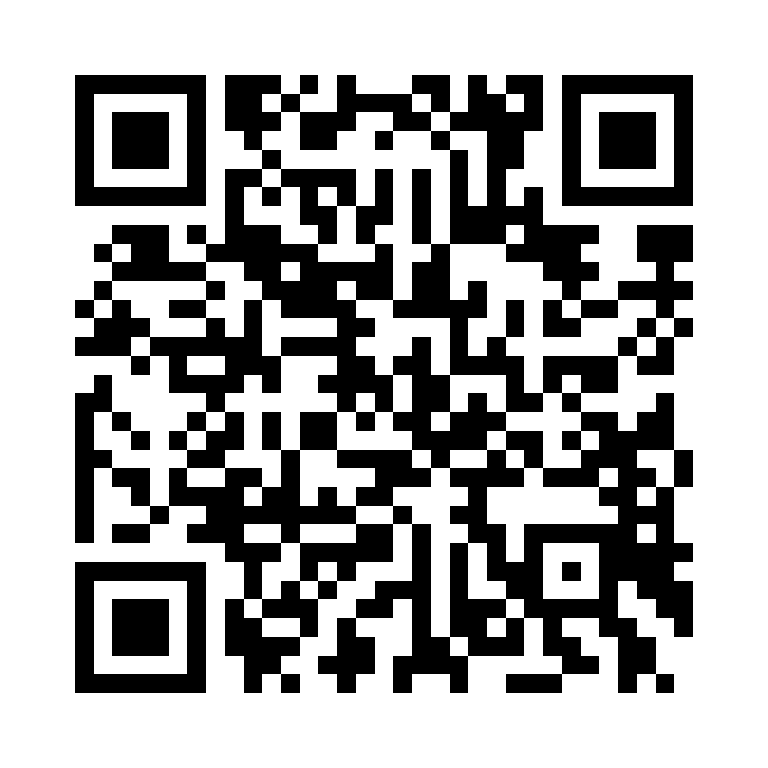

In [4]:
import qrcode
qr=qrcode.QRCode(version=1, error_correction=qrcode.constants.ERROR_CORRECT_H, box_size=10,border=4,)
qr.add_data("https://www.youtube.com/@YS-yb5cz")
qr.make(fit=True)
qrcode_image=qr.make_image(fill_color="black", back_color="white")

qrcode_image=qrcode_image.resize((768,768))
qrcode_image

# Import the Scheduler

In [5]:
from diffusers import DPMSolverMultistepScheduler
sampler=DPMSolverMultistepScheduler.from_config(pipe.scheduler.config, use_karras=True, algorithm_type="sde-dpmsolver++")
print(sampler)

DPMSolverMultistepScheduler {
  "_class_name": "DPMSolverMultistepScheduler",
  "_diffusers_version": "0.23.1",
  "algorithm_type": "sde-dpmsolver++",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "dynamic_thresholding_ratio": 0.995,
  "euler_at_final": false,
  "lambda_min_clipped": -Infinity,
  "lower_order_final": true,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "sample_max_value": 1.0,
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "solver_order": 2,
  "solver_type": "midpoint",
  "steps_offset": 1,
  "thresholding": false,
  "timestep_spacing": "linspace",
  "trained_betas": null,
  "use_karras_sigmas": false,
  "use_lu_lambdas": false,
  "variance_type": null
}



  0%|          | 0/36 [00:00<?, ?it/s]

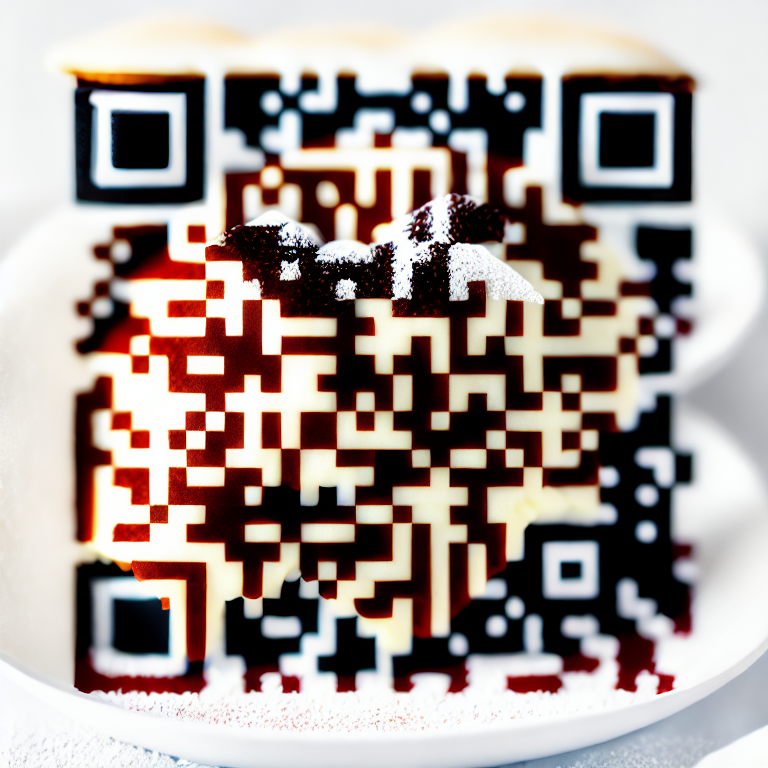

In [6]:
def inference(prompt,negative_prompt, 
              guidance_scale, 
              controlnet_conditioning_scale, 
              strength,seed,
              qrcode_image,
              sampler, 
              num_inference_steps):
    
    pipe.scheduler=sampler
    image=pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        image=qrcode_image,
        control_image=qrcode_image,
        width=768,
        height=768,
        guidance_scale=guidance_scale,
        controlnet_conditioning_scale=controlnet_conditioning_scale,
        generator=torch.manual_seed(seed),
        strength=strength,
        num_inference_steps=num_inference_steps,
    )
    return image
    

demo=inference(prompt="A close-up photo of a fluffy Japanese soufflé pancake with whipped cream and berries, with a sprinkle of powdered sugar, placed on a white plate with a logo in the corner reading Cooking with [Youtuber: Y.S].",
           negative_prompt="ugly, disfigured, low quality, blurry, nsfw",
           guidance_scale=7.5,
           controlnet_conditioning_scale=1.9,
           strength=0.9,
           seed=2024,
           qrcode_image=qrcode_image,
           sampler=sampler,
           num_inference_steps=40,
          )

demo.images[0]

  0%|          | 0/36 [00:00<?, ?it/s]

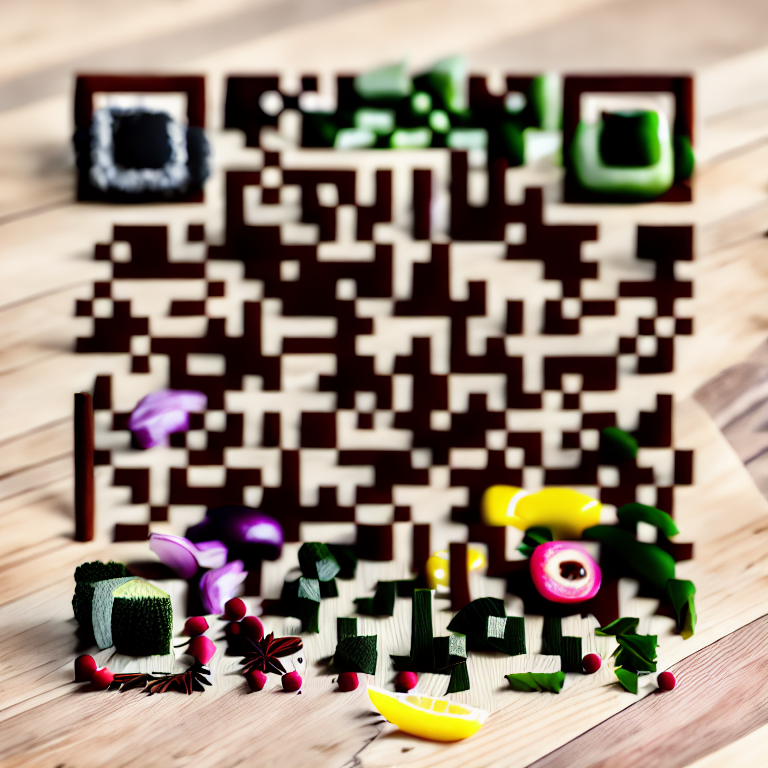

In [7]:
demo2=inference(prompt="A rustic still life of various cooking ingredients, including fresh herbs, colorful vegetables, and spices, arranged on a weathered wooden table.",
           negative_prompt="ugly, disfigured, low quality, blurry, nsfw",
           guidance_scale=7.5,
           controlnet_conditioning_scale=1.9,
           strength=0.9,
           seed=2024,
           qrcode_image=qrcode_image,
           sampler=sampler,
           num_inference_steps=40,
          )

demo2.images[0]

  0%|          | 0/36 [00:00<?, ?it/s]

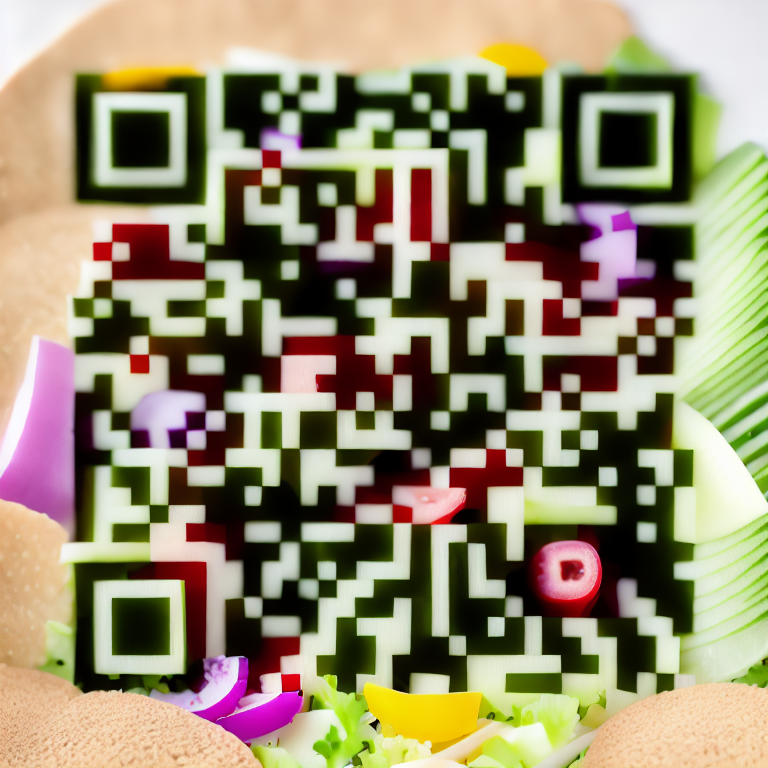

In [8]:
demo3=inference(prompt="A vibrant overhead shot of a colorful and healthy salad, with different textures and ingredients visible, ready to be enjoyed.",
           negative_prompt="ugly, disfigured, low quality, blurry, nsfw",
           guidance_scale=7.5,
           controlnet_conditioning_scale=1.9,
           strength=0.9,
           seed=2024,
           qrcode_image=qrcode_image,
           sampler=sampler,
           num_inference_steps=40,
          )

demo3.images[0]

# Saving the Image

In [9]:
demo3.images[0].save('demo3.png')